In [5]:
import time

import cv2
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor

from yolort.utils import Visualizer

from PIL import Image
import numpy as np

In [6]:
# configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_cuda = False if str(device) == "cpu" else True
weights_blood_det_th = "/home/ajvalenc/Projects/spectronix/detection_models/blood_fever/weights/torchscript/traced_blood_det_th-{}.pt".format(device).replace(":0","")
weights_blood_det_ir = "/home/ajvalenc/Projects/spectronix/detection_models/blood_fever/weights/torchscript/traced_blood_det_ir-{}.pt".format(device).replace(":0","")

In [7]:
print("Loading detection model...")
model_blood_det_th = torch.jit.load(weights_blood_det_th)
model_blood_det_ir = torch.jit.load(weights_blood_det_ir)
print("Detection models loaded successfully")

Loading detection model...
Detection models loaded successfully


In [8]:
# input data and transform (using opdirectory_th{"/home/ajvalenc/Datasets/spectronix/thermal/failure/"};
filename_th = "/home/ajvalenc/Datasets/spectronix/thermal/failure/1420.png"
filename_ir = "/home/ajvalenc/Datasets/spectronix/ir/failure/1420.png"
img_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH)
img_ir = cv2.imread(filename_ir, cv2.IMREAD_ANYDEPTH)

In [9]:
def sixteen_bits2eight_bits(pixel):
    # Pseudo colouring the 16 bit images
    pixel = (pixel - np.min(pixel)) / (30100-np.min(pixel))
    pixel = np.rint(pixel * 255)
    return pixel.astype("uint8")

In [18]:
# conversion
img_prc_th = sixteen_bits2eight_bits(img_th)
img_prc_th = cv2.cvtColor(img_prc_th, cv2.COLOR_GRAY2BGR)
ts_img_th = torch.as_tensor(img_prc_th.astype("float32").transpose(2,0,1)).to(device)
ts_img_th /= 255.
ts_img_th = ts_img_th.unsqueeze(0)

img_prc_ir = sixteen_bits2eight_bits(img_ir)
img_prc_ir = cv2.cvtColor(img_prc_ir, cv2.COLOR_GRAY2BGR)
ts_img_ir = torch.as_tensor(img_prc_ir.astype("float32").transpose(2,0,1)).to(device)
ts_img_ir /= 255.
ts_img_ir = ts_img_ir.unsqueeze(0)

In [11]:
# dry run
for i in range(3):
    model_blood_det_th(ts_img_th)
    model_blood_det_ir(ts_img_ir)

/home/ajvalenc/opt/miniconda3/envs/spectronix/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at ../third_party/nvfuser/csrc/parser.cpp:3777.)
  return forward_call(*args, **kwargs)
/home/ajvalenc/opt/miniconda3/envs/spectronix/lib/python3.8/site-packages/torch/nn/modules/module.py:1501: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return forward_call(*args, **kwargs)
code/__torch__/yolort/models/yolo.py:42: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.
code/__torch__/yolort/models/yolo/___torch_mangle_647.py:42: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.


In [12]:
with torch.no_grad(): #ensures autograd is off
    out_bdet_th = model_blood_det_th(ts_img_th)
    out_bdet_ir = model_blood_det_ir(ts_img_ir)

In [13]:
print("Output bdet th:", out_bdet_th[1][0])
print("Output bdet ir:", out_bdet_ir[1][0])

Output bdet th: {'scores': tensor([0.44970], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'boxes': tensor([[561.78882,  23.67214, 585.87378,  38.83502]], device='cuda:0')}
Output bdet ir: {'scores': tensor([], device='cuda:0'), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'boxes': tensor([], device='cuda:0', size=(0, 4))}


In [30]:
def visualize(image, normalize=False):

    if normalize:
        image = cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 

    # rescale (16-bit image only) see method 2 https://answers.opencv.org/question/207313/conversion-16bit-image-to-8-bit-image/
    if (image.dtype) == np.uint16:
        image = image / 257
        image = image.astype(np.uint8)

    #cv2.normalize(image, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) 
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

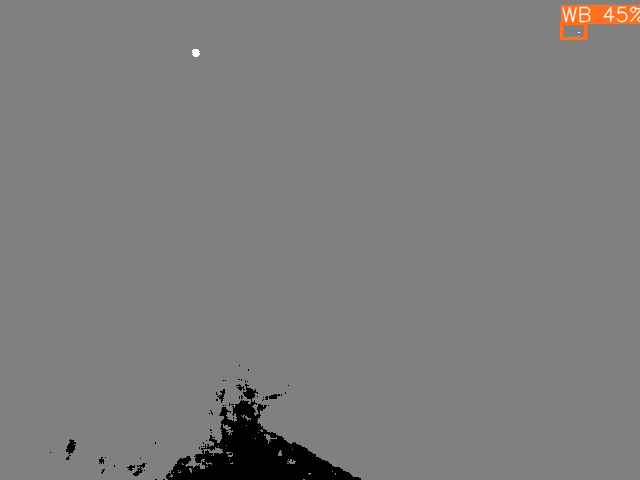

In [31]:
# verify results
img_raw_th = cv2.imread(filename_th, cv2.IMREAD_ANYDEPTH) #original
v = Visualizer(visualize(img_raw_th, True), ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet_th[1][0])
v.imshow(scale=1.0)

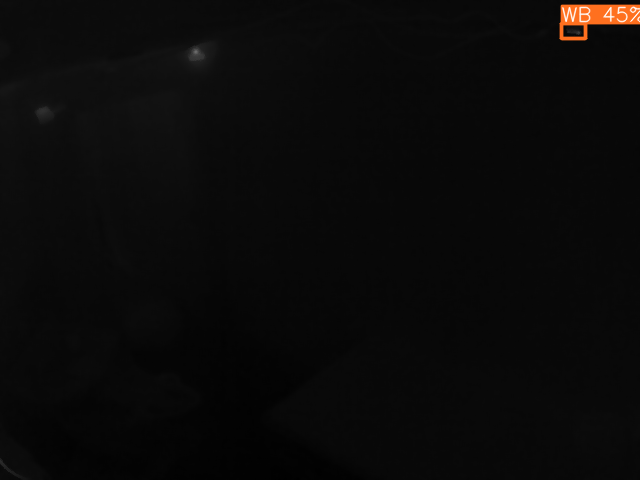

In [22]:
# verify results
img_raw_th = cv2.imread(filename_th) #original
#v = Visualizer(visualize(img_prc_th, False), ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v = Visualizer(img_prc_th, ["Cold_Background", "Cold_Body", "WB", "Warm_Body", "Warm_Dripping"])
v.draw_instance_predictions(out_bdet_th[1][0])
v.imshow(scale=1.0)

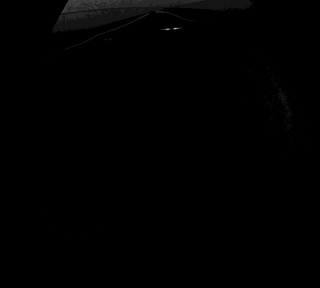

In [36]:
# verify results
img_raw_ir = cv2.imread(filename_ir) #original
v = Visualizer(visualize(img_raw_ir, True), ["Face", "ForeHead"])
v.draw_instance_predictions(out_bdet_ir[1][0])
v.imshow(scale=0.5)